In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
# from model import Brain
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)
from lib.sde.grn3 import GRNMain3
from lib.sde.mutate import mutate_grn2
from lib.ga.utils import weighted_selection_one
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L

In [3]:
HISTORY = defaultdict(dict)
HALL_OF_FAME = []

In [4]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [5]:
REF = O(
    stats=pd.read_csv("output/results/setup_basic/export/ref_basic2.csv"),  # ref is a mean
    # fmetric=setup_ref_fmetric("output/results/setup_basic/export/ref_fmetric_tristate.csv"),
)

In [6]:
def individual_generator(id_=-1):
    return Solution(GRNMain3(5, 0, 0), id_=id_)

In [7]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        for i in range(1):
            mutate_grn2(self.grn)
        # here force values
        self.grn.set_mutable()
        self.grn._params[4, :] = 1
        self.grn._params[5, :] = 0
        self.grn.compile()

In [8]:
# def score_bb_size(bb, ref, *args, **kwargs):
#     return score_both_size_norm(bb.stats, ref.stats, *args, **kwargs, norm=2.0)

In [9]:
def score_bb_size(bb, ref, *args, **kwargs):
    """Returns the max score of the subbrains
    It will later be translated to fitness (1 / score)"""
    score = 1e-9
    for i in range(3):
        new_score = (
            score_stats_norm(bb.stats, ref.stats, col_stats=f"tag_prog{i}",
                             col_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)
            + score_stats_norm(bb.stats, ref.stats, col_stats=f"tag_whole{i}",
                             col_ref="whole_pop_size", norm=2.0, *args, **kwargs)
        )
        score = max(score, new_score)
    return score

def score_bb_size_old(bb, ref, *args, **kwargs):
    return (
        score_stats_norm(bb.stats, ref.stats, col_stats=f"progenitor_pop_size",
                         col_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)
        + score_stats_norm(bb.stats, ref.stats, col_stats=f"whole_pop_size",
                         col_ref="whole_pop_size", norm=2.0, *args, **kwargs)
    )

In [10]:
def setup_tag(cp):
    indexes = list(cp.base_population.keys())
    shuffle(indexes)
    splits = np.array_split(indexes, 3)
    for i, ls in enumerate(splits):
        for idx in ls:
            cp.base_population[idx].tag["subbrain"] = i

In [11]:
def get_bb(prun, grn):
    ccls = factories["grn3"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        tag_prog0=TagNumberCallback(TargetPopulation.progenitor, "subbrain", 0, neg=True),
        tag_prog1=TagNumberCallback(TargetPopulation.progenitor, "subbrain", 1, neg=True),
        tag_prog2=TagNumberCallback(TargetPopulation.progenitor, "subbrain", 2, neg=True),
        tag_whole0=TagNumberCallback(TargetPopulation.whole, "subbrain", 0, neg=True),
        tag_whole1=TagNumberCallback(TargetPopulation.whole, "subbrain", 1, neg=True),
        tag_whole2=TagNumberCallback(TargetPopulation.whole, "subbrain", 2, neg=True),
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=7, max_pop_size=2e3,
            cell_cls=ccls, end_time=prun.end_time, start_time=50, silent=True,
              run_tissue=False, monitor_callbacks=callbacks, tag_func=setup_tag)
    return bb

In [12]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [13]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        # score_step = score_both_size(bb.stats, prun.ref, max_step=step.end_time, min_step=previous_time)
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

def score_multistep(prun, stats, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    # first step
    for i, step in enumerate(steps):
        # score_step = score_both_size(bb.stats, prun.ref, max_step=step.end_time, min_step=previous_time)
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        print(f"Score for step {i} is {score_step}")
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness
        previous_time = step.end_time
        
    return total_fitness

In [14]:
def mean_sd_fitness(prun, grn, run=3):
    fitnesses = [fitness_multistep(prun, grn) for i in range(run)]
    return np.mean(fitnesses), np.std(fitnesses)

In [15]:
def multi_fitness(*args):
    fitnesses = [fitness_multistep(*args) for i in range(3)]
    scores = [x[0] for x in fitnesses]
    return fitnesses[scores.index(min(scores))]

In [16]:
def do_init(prun):
    return individual_generator(provide_id())

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id())
    
    return weighted_selection_one(pop, pop_fit, individual_generator, new_fitness=0.5, id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [17]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 4
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps = [
    ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="3", start_time=56, end_time=59, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="4", start_time=59, end_time=62, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="5", start_time=62, end_time=65, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="6", start_time=65, end_time=68, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="7", start_time=68, end_time=71, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="8", start_time=71, end_time=74, score_func=score_bb_size, min_fitness=0.5),
    ObjectiveStep(name="9", start_time=74, end_time=77, score_func=score_bb_size, min_fitness=0.5),
]

example_steps2 = [
    ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size_old),
    ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size_old),
    ObjectiveStep(name="3", start_time=56, end_time=59, score_func=score_bb_size_old),
    ObjectiveStep(name="4", start_time=59, end_time=62, score_func=score_bb_size_old),
    ObjectiveStep(name="5", start_time=62, end_time=65, score_func=score_bb_size_old),
    ObjectiveStep(name="6", start_time=65, end_time=68, score_func=score_bb_size_old),
    ObjectiveStep(name="7", start_time=68, end_time=71, score_func=score_bb_size_old),
    ObjectiveStep(name="8", start_time=71, end_time=74, score_func=score_bb_size_old),
    ObjectiveStep(name="9", start_time=74, end_time=77, score_func=score_bb_size_old),
]

class ParamRun(O):
    pop_size = 10
    n_gen = 20
    current_gen = 0
    end_time = 83
    ref = REF
    min_pop = 20
    max_pop = 50

args = ParamRun()
args.steps = example_steps
args2 = ParamRun()
args2.steps = example_steps2
for step in args.steps:
    step.reset()

In [18]:
def main(prun):
    prun.history = defaultdict(dict)
    exporter = Exporter()
    best = 0
    sol = do_init(prun)
    pop = [sol]
    for generation in range(prun.n_gen * prun.pop_size):
        # args.generation = generation
        # objective.new_trial()
        fit, stats = do_fitness(prun, sol)
        sol.fit = fit
        sol.stats = stats
        
        # history
        # print(f"Fitness = {fit}", end="\t\t")
        if generation % 100 == 0:
            print(f"Step {generation}")
        if fit > best:
            print(f"++ Best {fit} for generation {generation}")
            best = fit
            
        monitor = sol
        prun.history[generation] = monitor
        exporter(monitor, f"generation_g{generation}")
        
        # TODO get the stats associated with the best scores
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
    print("OVER")
    return best

In [ ]:
sol = main(args)

Exporting at output/2022-01-29/18:25:10.282928_828975
Step 0
++ Best 0.00070325909216422 for generation 0
++ Best 0.09270037485622774 for generation 1
++ Best 0.1771742034859034 for generation 2
Step 1 passed !
Step 2 passed !
Step 3 passed !
++ Best 4.005593130809819 for generation 7
++ Best 6.864763241667887 for generation 25
++ Best 8.036546605963457 for generation 52
Step 4 passed !
Step 100
Step 5 passed !
++ Best 9.528180968808487 for generation 150


In [20]:
sol = main(args2)

OVER


In [29]:
p2 = L(args2.history.values()).fit
p1 = L(args.history.values()).fit

In [33]:
max(p1), max(p2)

(9.528180968808487, 9.034355674749465)

In [30]:
p2.index(max(p2)), p1.index(max(p1))

(101, 150)

In [31]:
args.history[150].stats

,neuron_pop_size,progenitor_pop_size,tag_prog0,tag_prog1,tag_prog2,tag_whole0,tag_whole1,tag_whole2,time,whole_pop_size
50.0,0.0,49.0,32.0,33.0,33.0,32.0,33.0,33.0,50.0,49.0
50.5,8.0,68.0,43.0,46.0,47.0,64.0,69.0,73.0,50.5,76.0
51.0,8.0,68.0,43.0,46.0,47.0,64.0,69.0,73.0,51.0,76.0
51.5,9.0,69.0,45.0,46.0,47.0,68.0,71.0,75.0,51.5,78.0
52.0,11.0,70.0,45.0,46.0,49.0,72.0,73.0,81.0,52.0,81.0
52.5,13.0,71.0,45.0,48.0,49.0,76.0,77.0,85.0,52.5,84.0
53.0,15.0,71.0,45.0,48.0,49.0,80.0,77.0,89.0,53.0,86.0
53.5,16.0,77.0,48.0,54.0,52.0,88.0,89.0,97.0,53.5,93.0
54.0,18.0,83.0,52.0,58.0,56.0,100.0,101.0,105.0,54.0,101.0
54.5,18.0,87.0,55.0,61.0,58.0,106.0,107.0,109.0,54.5,105.0


In [32]:
args2.history[101].stats

,neuron_pop_size,progenitor_pop_size,tag_prog0,tag_prog1,tag_prog2,tag_whole0,tag_whole1,tag_whole2,time,whole_pop_size
50.0,0.0,49.0,32.0,33.0,33.0,32.0,33.0,33.0,50.0,49.0
50.5,3.0,54.0,36.0,35.0,37.0,44.0,43.0,43.0,50.5,57.0
51.0,3.0,63.0,42.0,39.0,45.0,56.0,51.0,59.0,51.0,66.0
51.5,4.0,71.0,48.0,42.0,52.0,70.0,59.0,73.0,51.5,75.0
52.0,9.0,76.0,49.0,44.0,59.0,80.0,73.0,89.0,52.0,85.0
52.5,12.0,82.0,52.0,50.0,62.0,90.0,87.0,101.0,52.5,94.0
53.0,14.0,88.0,55.0,55.0,66.0,100.0,97.0,113.0,53.0,102.0
53.5,15.0,103.0,68.0,60.0,78.0,126.0,109.0,139.0,53.5,118.0
54.0,19.0,112.0,73.0,66.0,85.0,142.0,125.0,159.0,54.0,131.0
54.5,22.0,128.0,79.0,79.0,98.0,158.0,153.0,191.0,54.5,150.0


In [35]:
ls1 = [fitness_multistep(args2, args.history[150].grn, args2.steps)[0] for i in range(10)]

In [36]:
ls2 = [fitness_multistep(args2, args2.history[101].grn, args2.steps)[0] for i in range(10)]

In [37]:
np.mean(ls1), np.std(ls1), np.mean(ls2), np.std(ls2)

(3.366793123078024, 0.9454527460370296, 5.404125564106699, 2.283264484351395)

In [38]:
ls1

[2.311331307812164,
 2.370662815320415,
 3.0983620752308134,
 5.634189568763518,
 3.0170227778500704,
 4.0198977433245675,
 3.816475731833611,
 3.5560885054334137,
 3.389224114092156,
 2.4546765911195143]

In [39]:
ls2

[8.947017872195481,
 2.590918334334935,
 7.4432313270223025,
 5.010472043910025,
 6.653963051417746,
 2.3432360006136532,
 2.481384423701573,
 7.9096096291395135,
 6.2229128944385845,
 4.438510064293176]

In [23]:
raise

RuntimeError: No active exception to reraise

In [ ]:
sols = list(HISTORY.values())
fits = [sol.fit for sol in sols]
idx = fits.index(max(fits))
sol = sols[idx]

In [ ]:
sol.fit

In [40]:
def show_curve(stats, ref, max_step=None, show=True):
    """
    The evaluation function for progenitor population size.
    The lower is the better
    :param stats: the stats of the bb after running
    """
    stats, ref = shrink_and_align_stats(stats, ref, max_step=max_step)
    
    x, y = preprocess_progenitor_size(stats, ref)
    
    plt.plot(ref.index, x, label="Reference Prog")
    plt.plot(ref.index, y, label="Simulation Prog")
    
    x, y = preprocess_whole_size(stats, ref)
    
    plt.plot(ref.index, x, label="Reference Whole")
    plt.plot(ref.index, y, label="Simulation Whole")
    
    plt.legend()
    
    if show:
        plt.show()

In [41]:
def print_fmetrics(population, ref):
    pairs = get_fmetric_pairs(population, min_time=50, max_time=60)
    fmetric = fate_corr(pairs)
    print(f"Population : {fmetric}, ref : {ref[50][60]}")

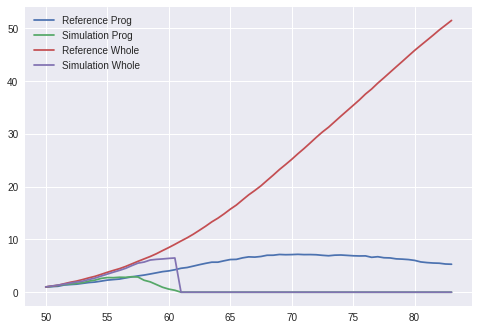

In [45]:
show_curve(args2.history[101].stats, REF.stats, max_step=args.end_time)

In [ ]:
score_multistep(args, stats, args.steps)

In [ ]:
REF.head(10)

In [ ]:
def fill_df(stats, ls_val):
    for time, prog_pop, whole_pop in ls_val:
        stats.loc[time] = {"progenitor_pop_size": prog_pop, "time": time, "whole_pop_size": whole_pop}

In [ ]:
vals = [
    (50.5, 25, 27),
    (51., 26, 30),
    (51.5, 27, 40),
    (52., 30, 50),
    (52.5, 35, 60),
    (53., 40, 27),
    (53.5, 45, 27),
    (54., 50, 27),
    (54.5, 55, 27),
    (55., 60, 27),
]

In [ ]:
fill_df(stats, ls_val=vals)
stats

In [ ]:
show_curve(stats, REF.stats, max_step=55)
print_fmetrics(population, REF.fmetric)
score_multistep(args, stats, args.steps)

In [ ]:
# peut être mettre sqrt plutôt que abs en dénominateur
# ensuite équilibrer les fit value en normalisant avec la médiane ou la moyenne ou autre (3e quartile ?)